# `Artificial Intelligence (AI) - Final Project     `
## `Badal Parmar - 18BCP011`

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import preprocessing
from sklearn import metrics

from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# Import libraries for k-fold and cross validation, to test model accuracy using a mean score of k
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LinearRegression

# Import libraries from sklearn to create the models used for classification
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

# Import libraries to be used for accuracy score, classification report in form of a confusion matrix
# and the code to find the mean absolute error of the model
from sklearn.metrics import accuracy_score
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import DiscriminationThreshold
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Import libraries for decision tree creation
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
from IPython.display import Image
import pydotplus

## Data Exploration

In [ ]:
#Loading the dataset into a DataFrame

data = pd.read_csv("600092_data.csv")
data.head()

,Random,Id,Indication,Diabetes,IHD,Hypertension,Arrhythmia,History,IPSI,Contra,label
0,0.602437,218242,A-F,no,no,yes,no,no,78.0,20,NoRisk
1,0.602437,159284,TIA,no,no,no,no,no,70.0,60,NoRisk
2,0.602437,106066,A-F,no,yes,yes,no,no,95.0,40,Risk
3,0.128157,229592,TIA,no,no,yes,no,no,90.0,85,Risk
4,0.676862,245829,CVA,no,no,no,no,no,70.0,20,NoRisk


In [ ]:
# Find out some stats regarding the current dataset
data.describe(include='all')

,Random,Id,Indication,Diabetes,IHD,Hypertension,Arrhythmia,History,IPSI,Contra,label
count,1520.000000,1520.000000,1517,1518,1520,1517,1520,1518,1516.000000,1520,1517
unique,NaN,NaN,5,2,2,2,2,2,NaN,41,3
top,NaN,NaN,A-F,no,no,no,no,no,NaN,100,NoRisk
freq,NaN,NaN,493,1441,801,784,1190,1494,NaN,244,1008
mean,0.509545,188365.022368,NaN,NaN,NaN,NaN,NaN,NaN,78.872032,NaN,NaN
std,0.284006,64355.870242,NaN,NaN,NaN,NaN,NaN,NaN,10.162351,NaN,NaN
min,0.000295,78261.000000,NaN,NaN,NaN,NaN,NaN,NaN,35.000000,NaN,NaN
25%,0.268531,137130.750000,NaN,NaN,NaN,NaN,NaN,NaN,73.000000,NaN,NaN
50%,0.517616,191344.500000,NaN,NaN,NaN,NaN,NaN,NaN,77.000000,NaN,NaN
75%,0.754724,244559.500000,NaN,NaN,NaN,NaN,NaN,NaN,85.000000,NaN,NaN


https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html

Running the describe function here shows there isn't many numeric columns in the dataset, Next lets check the types.

In [ ]:
# View the datatypes for each column of the dataframe
data.dtypes

Random          float64
Id                int64
Indication       object
Diabetes         object
IHD              object
Hypertension     object
Arrhythmia       object
History          object
IPSI            float64
Contra           object
label            object
dtype: object

In [ ]:
# Check how many values exist
data.count()

Random          1520
Id              1520
Indication      1517
Diabetes        1518
IHD             1520
Hypertension    1517
Arrhythmia      1520
History         1518
IPSI            1516
Contra          1520
label           1517
dtype: int64

In [ ]:
# Additional information regarding the values of the dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1520 entries, 0 to 1519
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Random        1520 non-null   float64
 1   Id            1520 non-null   int64  
 2   Indication    1517 non-null   object 
 3   Diabetes      1518 non-null   object 
 4   IHD           1520 non-null   object 
 5   Hypertension  1517 non-null   object 
 6   Arrhythmia    1520 non-null   object 
 7   History       1518 non-null   object 
 8   IPSI          1516 non-null   float64
 9   Contra        1520 non-null   object 
 10  label         1517 non-null   object 
dtypes: float64(2), int64(1), object(8)
memory usage: 130.8+ KB


Contra is an object, it should be a number and therefroe needs to be converted. This will be done during the initial EDA.

## Performing Initial Exploratory Data Analysis

The first step is to clean the data of any missing values. If the amount of missing values is insignificant to the overall dataset, due to the nature of this domain it would be difficult to impute data here. In the case of missing data in this dataframe, it will be removed unless the number of missing values is too substantial. If that is the case then it is worthwhile to attempt an imputation method, which will be discussed if necessary.

The column 'Label' is the most important attribute as this is where the main classification will take place, lets check how many Risk and No Risk values there are within this column.

In [ ]:
# Create a new dataframe that only contains the values within the column label, and then count them
data["label"].value_counts()

NoRisk     1008
Risk        507
Unknown       2
Name: label, dtype: int64

There are 2 Unknown values, alongside risk and no risk results.
According to the domain documentation, there should only be 2 values in this column, which are Risk and NoRisk.

In [ ]:
# Show only the values with an unknown label value
label = data[data["label"] == "Unknown"]
label

,Random,Id,Indication,Diabetes,IHD,Hypertension,Arrhythmia,History,IPSI,Contra,label
475,0.298074,173791,ASx,no,yes,yes,no,no,70.0,55,Unknown
523,0.460170,283846,CVA,no,no,yes,yes,no,95.0,100,Unknown


As the aim of the classification is to predict if a user will be of No Risk or Risk, Unknown is not good here. It is not possible to choose the correct validation here, so the Unknown values with be replaced with nan values that will be removed with any other null values.

It is important to note, while there is a consideration to keep the values in, since the number of unknown values is only 2 out of a potential 1520 (the total of all columns), removal of these 2 records will not have much impact.

In [ ]:
# Replace any values in the column label that equal Unknown into a NaN value
data["label"] = data["label"].replace("Unknown", np.nan)

In [ ]:
# Create a list that only includes the column data for Random and Id
del_col_list = ['Random', 'Id']

As Random and ID are simply unique identifiers to assign a number to a particular user, they are of no use for classification, so they will be removed. The reason for this is explained in more detail within the report.

In [ ]:
# Create a new dataframe without random and ID
clean_data = data.drop(del_col_list, axis=1)
clean_data.head()

,Indication,Diabetes,IHD,Hypertension,Arrhythmia,History,IPSI,Contra,label
0,A-F,no,no,yes,no,no,78.0,20,NoRisk
1,TIA,no,no,no,no,no,70.0,60,NoRisk
2,A-F,no,yes,yes,no,no,95.0,40,Risk
3,TIA,no,no,yes,no,no,90.0,85,Risk
4,CVA,no,no,no,no,no,70.0,20,NoRisk


In [ ]:
# Indication column has 4 expected values, lets check them
clean_data["Indication"].value_counts()

A-F    493
CVA    416
TIA    390
ASx    186
Asx     32
Name: Indication, dtype: int64

There are values present with ASx and Asx. These values were changed as per a website I found regarding Asx, and so the column name was changed to represent that.
https://medical-dictionary.thefreedictionary.com/Asx

In [ ]:
# Replace all values with ASx to Asx to match majority of values in the dataframe
clean_data["Indication"] = clean_data["Indication"].replace("ASx", "Asx")
clean_data["Indication"].value_counts()

A-F    493
CVA    416
TIA    390
Asx    218
Name: Indication, dtype: int64

In [ ]:
# Convert all values of the Contra column to numeric values
# any blank values found will be converted to NaN via errors='coerce'

clean_data["Contra"] = pd.to_numeric(clean_data["Contra"], errors="coerce")

In [ ]:
# Finding all values that contain null values
null_data = clean_data[clean_data.isnull().any(axis=1)]
print("The length of the null values dataframe is:",len(null_data))
null_data

The length of the null values dataframe is: 20


,Indication,Diabetes,IHD,Hypertension,Arrhythmia,History,IPSI,Contra,label
201,CVA,yes,no,NaN,yes,no,95.0,90.0,Risk
337,CVA,no,yes,no,no,NaN,85.0,50.0,NoRisk
442,NaN,no,yes,yes,no,no,70.0,40.0,NoRisk
447,CVA,NaN,yes,yes,yes,no,90.0,100.0,Risk
453,Asx,no,no,yes,no,no,70.0,NaN,NoRisk
475,Asx,no,yes,yes,no,no,70.0,55.0,NaN
514,A-F,NaN,no,yes,no,no,80.0,40.0,NoRisk
523,CVA,no,no,yes,yes,no,95.0,100.0,NaN
590,A-F,no,no,NaN,no,no,78.0,30.0,NoRisk
620,A-F,no,no,no,no,no,NaN,100.0,Risk


It's important to first check how much of a percentage these records are before deciding if it is worthwhile to categorically fill them or simply remove them.

In [ ]:
#percentage of missing values in the dataset
null_data_percent = clean_data.isnull().sum() * 100 / len(clean_data)
print(null_data_percent)

Indication      0.197368
Diabetes        0.131579
IHD             0.000000
Hypertension    0.197368
Arrhythmia      0.000000
History         0.131579
IPSI            0.263158
Contra          0.065789
label           0.328947
dtype: float64


This shows the percentage of values that are missing are fairly insignificant and will likely have no impact on the dataset, so they are safe to remove.

In [ ]:
# Drop all data values that are null
clean_data = clean_data.dropna()
clean_data.isnull().sum()

Indication      0
Diabetes        0
IHD             0
Hypertension    0
Arrhythmia      0
History         0
IPSI            0
Contra          0
label           0
dtype: int64

The result shows there are no more null values present, and EDA can continue.

In [ ]:
# Perform a new count to check how many values are present after removal
clean_data.count()

Indication      1500
Diabetes        1500
IHD             1500
Hypertension    1500
Arrhythmia      1500
History         1500
IPSI            1500
Contra          1500
label           1500
dtype: int64

In [ ]:
# Find out stats regarding the current dataset
clean_data.describe(include='all')

,Indication,Diabetes,IHD,Hypertension,Arrhythmia,History,IPSI,Contra,label
count,1500,1500,1500,1500,1500,1500,1500.000000,1500.000000,1500
unique,4,2,2,2,2,2,NaN,NaN,2
top,A-F,no,no,no,no,no,NaN,NaN,NoRisk
freq,489,1425,789,777,1177,1478,NaN,NaN,1000
mean,NaN,NaN,NaN,NaN,NaN,NaN,78.828000,56.668000,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,10.159555,29.524977,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,35.000000,10.000000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,73.000000,30.000000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,77.000000,50.000000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,85.000000,85.000000,NaN


In [ ]:
# Run a check to make sure the label column only has risk and no risk
clean_data["label"].value_counts()

NoRisk    1000
Risk       500
Name: label, dtype: int64

As this point, the data has been cleaned. woohoo.

The next step is to change the yes and no results to 0 and 1, so they can be more easily visualised.

### Preprocessing the data using One-Hot Encoding

Next step, will be to run the LabelEncoder feature of sklearn to change all the categorical yes and no values to numbers. Risk and NoRisk will be changed using the get_dummies features and added to a separate dataframe.

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

First we need to know what unique labels we have for each column of the dataset, so we will find those first.

In [ ]:
print("Indication' : ",clean_data['Indication'].unique())
print("Diabetes' : ",clean_data['Diabetes'].unique())
print("IHD' : ",clean_data['IHD'].unique())
print("Hypertension' : ",clean_data['Hypertension'].unique())
print("Arrhythmia' : ",clean_data['Arrhythmia'].unique())
print("History' : ",clean_data['History'].unique())
print("label' : ",clean_data['label'].unique())

Indication' :  ['A-F' 'TIA' 'CVA' 'Asx']
Diabetes' :  ['no' 'yes']
IHD' :  ['no' 'yes']
Hypertension' :  ['yes' 'no']
Arrhythmia' :  ['no' 'yes']
History' :  ['no' 'yes']
label' :  ['NoRisk' 'Risk']


Now that we know these values, we can create a new dataframe that will only include the dummy versions of these, through the use of the LabelEncoder sklearn preprocessing method.

In [ ]:
# create the Labelencoder object
le = preprocessing.LabelEncoder()

# Create a dummy for the column label to better visualise risk vs no risk
clean_data_risk = pd.get_dummies(clean_data["label"])

# convert the categorical columns into numeric
clean_data['Diabetes'] = le.fit_transform(clean_data['Diabetes'])
clean_data['IHD'] = le.fit_transform(clean_data['IHD'])
clean_data['Hypertension'] = le.fit_transform(clean_data['Hypertension'])
clean_data['Arrhythmia'] = le.fit_transform(clean_data['Arrhythmia'])
clean_data['History'] = le.fit_transform(clean_data['History'])

In [ ]:
# Add the dummy variable we created to the end of our current table
clean_data = pd.concat([clean_data, clean_data_risk], axis=1)
clean_data.head()

#Warning.. running this more than once will create duplicated dummy variables in the dataframe

,Indication,Diabetes,IHD,Hypertension,Arrhythmia,History,IPSI,Contra,label,NoRisk,Risk
0,A-F,0,0,1,0,0,78.0,20.0,NoRisk,1,0
1,TIA,0,0,0,0,0,70.0,60.0,NoRisk,1,0
2,A-F,0,1,1,0,0,95.0,40.0,Risk,0,1
3,TIA,0,0,1,0,0,90.0,85.0,Risk,0,1
4,CVA,0,0,0,0,0,70.0,20.0,NoRisk,1,0


This presents a small problem of duplication, for the time being a new table can be created which will not include the label column, but the original table will be kept

In [ ]:
# Create a new variable for the label column
clean_data_label = ["label"]

# Create a new dataframe, and then drop the label column using the variable created above
clean_data_dummy = clean_data.drop(clean_data_label, axis=1)
clean_data_dummy.head()

,Indication,Diabetes,IHD,Hypertension,Arrhythmia,History,IPSI,Contra,NoRisk,Risk
0,A-F,0,0,1,0,0,78.0,20.0,1,0
1,TIA,0,0,0,0,0,70.0,60.0,1,0
2,A-F,0,1,1,0,0,95.0,40.0,0,1
3,TIA,0,0,1,0,0,90.0,85.0,0,1
4,CVA,0,0,0,0,0,70.0,20.0,1,0


## Visualising the data

Lets visualise the data now. This makes it is easier for us to see patterns in data through this method than just looking at dataframes.

The first visualisation technique used is a bar chart. From exploring the data briefly, there are 4 indication types. Lets see how many risk and no risk patients are in the dataset that accompany each of these indications.

Text(0.5, 1.0, 'Indication count of Risk/NoRisk')

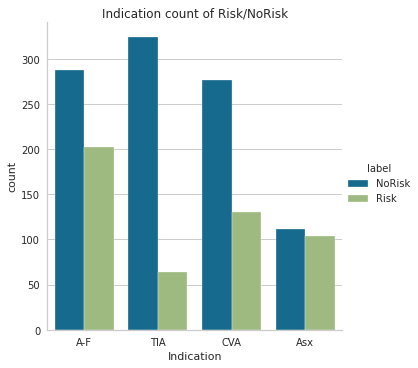

In [ ]:
sns.set_style("whitegrid")
vis4 = sns.catplot(x="Indication", hue="label", data=clean_data, kind="count")
plt.title("Indication count of Risk/NoRisk")

The initial reaction here, is that the majority of TIA labeled patients in the dataset are classified as a norisk patient. CVA also has a much higher norisk result than that of those laballed as to be at risk.

Lets take a brief look at the mean scores for each numerical value alongside the amount of risk and norisk patients in each section.

In [ ]:
# Mean scores for each Indication alongside each label
clean_data_dummy.groupby(["Indication", "Risk", "NoRisk"]).mean()

Diabetes       IHD  Hypertension  Arrhythmia  \
Indication Risk NoRisk                                                 
A-F        0    1       0.000000  0.421603      0.282230    0.000000   
           1    0       0.113861  0.633663      0.589109    0.584158   
Asx        0    1       0.000000  0.330357      0.267857    0.000000   
           1    0       0.144231  0.673077      0.865385    0.653846   
CVA        0    1       0.021661  0.382671      0.371841    0.025271   
           1    0       0.053846  0.661538      0.923077    0.892308   
TIA        0    1       0.000000  0.373457      0.404321    0.009259   
           1    0       0.375000  0.656250      0.765625    0.171875   

                         History       IPSI     Contra  
Indication Risk NoRisk                                  
A-F        0    1       0.000000  76.452962  39.233449  
           1    0       0.009901  87.559406  81.267327  
Asx        0    1       0.000000  78.151786  35.705357  
           1    0       0.000000  82.788462  82.259615  
CVA        0    1       0.007220  74.877256  46.028881  
           1    0       0.030769  85.969231  88.038462  
TIA        0    1       0.040123  73.669753  46.595679  
           1    0       0.015625  85.375000  85.625000

This table of results shows that patients who have a risk classification, have much higher mean scores in terms of Contra, not so much the case with IPSI. Most of the norisk patients have a classification mean score which is relatively low in comparison.

### Pairplots & Correlation

The pairplot function of seaborn is useful to see multiple plots in a single result rather than needing to input multiple solo plots. The plots below show how the Contra and IPSI correlate with each other, whilst also showing what values of the dataset lead to the risk and norisk classification in the label column.

https://seaborn.pydata.org/generated/seaborn.pairplot.html

Text(0.5, 1.0, 'Pairplot of IPSI and Contra against Risk classification')

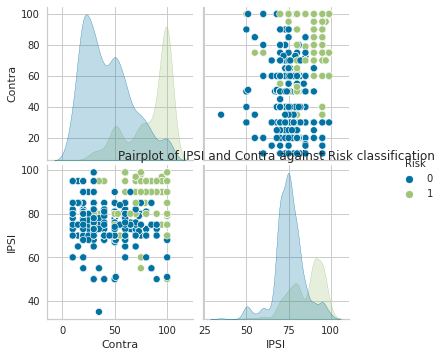

In [ ]:
medical = clean_data_dummy
g = sns.pairplot(medical, hue="Risk", vars=["Contra", "IPSI"])
plt.title("Pairplot of IPSI and Contra against Risk classification")

The values shown as green are the values that are of a risk label, whilst the blue show the values to which there is a norisk label. What's important here is that it appears that risk is associated with a high Contra score, whilst IPSI is not as important.

We can better visualise the correlation here by placing the values into a correlation matrix.

https://seaborn.pydata.org/generated/seaborn.heatmap.html?highlight=heatmap#seaborn.heatmap

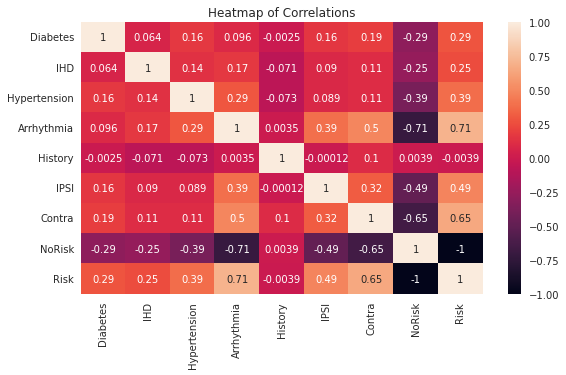

In [ ]:
plt.figure(figsize=(9,5))
plt.title("Heatmap of Correlations")
sns.heatmap(clean_data_dummy.corr(), annot=True)

Its possible to see from the heatmap a more numerical representation of the correlations. Contra has a 0.65 positive correlation with Risk, and a -0.65 negative correlation with NoRisk. This indicates that when the Contra score increases, the chance of Risk also increases.

IPSI sits at a 0.49 and -0.49 score respectively, which shows while it does have a positive/negative correlation with each result, it is not as impactful as Contra is.

The correlation relationship of Risk against NoRisk is an expected exact -1. This indicates there is a perfect downhill negative relationship for NoRisk against Risk. A 1 score just means there is an exact uphill positive relationship, but is expected as the value is being tested against itself, and this result is always expected to be 1.

The most interesting Correlation score from the heatmap however, is Arrhythmia. It has a 0.71 for Risk and -0.71 for NoRisk. Taking into consideration what this attribute represents, it makes sense that it has the highest correlation with the outcome.

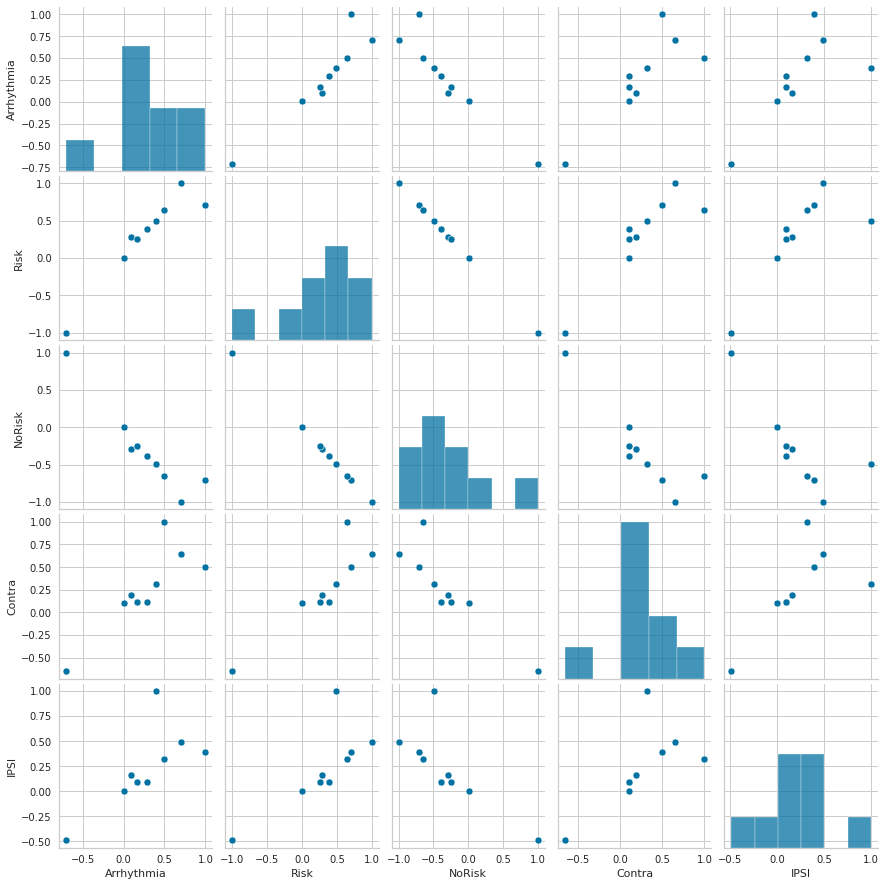

In [ ]:
sns.pairplot(medical.corr(), vars=["Arrhythmia","Risk", "NoRisk", "Contra", "IPSI"])

### Distribution

Next, we can visualise the distribution of the values for IPSI and Contra across the whole dataset.

https://seaborn.pydata.org/generated/seaborn.distplot.html

The values of IPSI are right skewed, whilst the Contra values are more evenly distributed.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


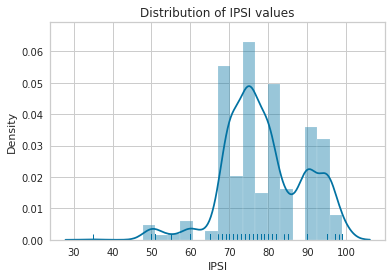

In [ ]:
# Visualise the distribution across the IPSI value
sns.distplot(clean_data["IPSI"], bins = 20, rug=True)
plt.title("Distribution of IPSI values")
plt.ylabel("Density")
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


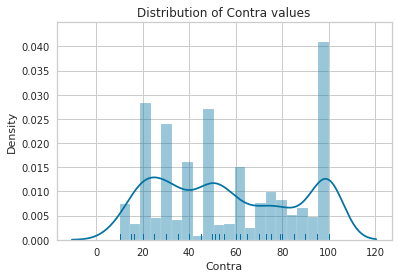

In [ ]:
# Visualise the distribution across the Contra value
sns.distplot(clean_data["Contra"], bins = 20, rug=True)
plt.title("Distribution of Contra values")
plt.ylabel("Density")
plt.show()

The distribution graphs help to give a visual understanding of where most of the values lie in the dataset. The IPSI data tends to fall mostly in the 60-80 value area, as indicated by the distribution line, whilst the Contra tends to have a more equal variation of values that flow across the entire dataset, with the highest values seemingly appearing at a 100 value, the highest possible value.

### Boxplots

A boxplot is the next graph that will be used to visualise the data. A boxplot is useful to show the distribution of the quantitative data in a way that helps to facilitate comparisons, in this case the comparisons of the quantitative data towards risk and norisk.

The boxes indicate the interquartile range, and the line in the centre of each boxplot indicates where the median of the box lies. The whiskers are used to show the extent of the rest of the values, with the diamonds at either side showing the outliers of the dataset in this particular boxplot.

https://seaborn.pydata.org/generated/seaborn.boxplot.html

From the IPSI boxplot below, the majority of the IPSI values for norisk are below 80, with a few outliers nearer the bottom of the boxplot, and a single outlier located at the value of 99. Whilst the risk patients generally have a score above 80, with the median here of 89. A few outliers are present for the risk patients, who have a IPSI value between 50 and 60.

Text(0.5, 1.0, 'Boxplot of IPSI scores against Risk/NoRisk')

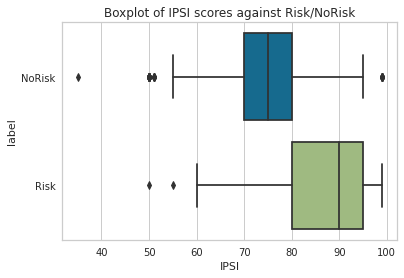

In [ ]:
# Create a boxplot that uses IPSI as the quantitative measure, and the label as the comparison
sns.boxplot(x = clean_data["IPSI"], y = clean_data["label"])
plt.title("Boxplot of IPSI scores against Risk/NoRisk")

From the Contra boxplot, the picture is much clearer. The majority of norisk patients have a Contra value below 60 and no visible outliers. The risk patients are mostly above 75, with the median here of around 96, a very high value, with a few outliers below 40.

Text(0.5, 1.0, 'Boxplot of Contra scores against Risk/NoRisk')

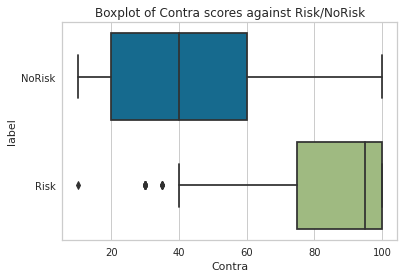

In [ ]:
# Create a boxplot that uses Contra as the quantitative measure, and the label as the comparison
sns.boxplot(x = clean_data["Contra"], y = clean_data["label"])
plt.title("Boxplot of Contra scores against Risk/NoRisk")

This shows that the overall distribution of Contra values is of more importance than IPSI values, as the majority of risk patients maintain high Contra scores, with a lower distribution being below a value of 40.

While IPSI having a high value doesn't necessarily mean you are of risk, having a high Contra score means that the majority of the time, you will end up with a classification of risk.

The next thing to look at, is distribution of IPSI and Contra towards which indication they are assigned to.

Text(0.5, 1.0, 'Boxplot of IPSI against each Indication')

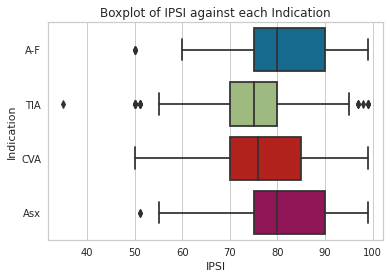

In [ ]:
# Create a boxplot that uses IPSI as the quantitative measure, and the Indication as the comparison
sns.boxplot(x = clean_data["IPSI"], y = clean_data["Indication"])
plt.title("Boxplot of IPSI against each Indication")

As seen before, the IPSI values generally seem to more distributed between 70 and 100 across all 4 indication classes. There are a few outliers between the different classes, but none that seem to be substantial here.

The boxplot against the Indication class sees no real difference here, as the values are mostly distributed in a way that doesn't give a clear insight as to whether the Indication class has an effect on the end classification.

The boxplot for the Contra however is a little bit more interesting.

Text(0.5, 1.0, 'Boxplot of Contra against each Indication')

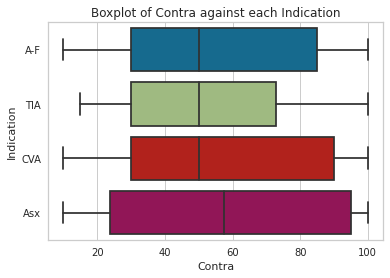

In [ ]:
# Create a boxplot that uses Contra as the quantitative measure, and the Indication as the comparison
sns.boxplot(x = clean_data["Contra"], y = clean_data["Indication"])
plt.title("Boxplot of Contra against each Indication")

Whilst the boxplot for IPSI toward Indication class is mostly as expected due to the rigth skewing of the data, the Contra boxplot is more interesting. This is because the wide variety of Contra values range across all classes and shows no outliers at all. 

The most important thing to get from this boxplot, is the Asx class, and TIA class. The Asx class has a very high spread of data within its interquartile range, whilst TIA is more evenly spread across the middle of the dataset. We can also see that 3 of the 4 classes have an exact median score of around 50, whilst Asx has a slightly higher median of around 58.

### Normalise the values

https://www.statisticshowto.datasciencecentral.com/normalized/

Normalisation is a key technique for the machine learning aspect of this analysis. It helps to change the values to a common scale, without distorting the differences in the ranges of values. It changes all values to instead have a value between 0 and 1, which is known as -feature scaling-

It is achieved by the following equation;

![image.png](attachment:image.png)

In [ ]:
# Normalise the IPSI and Contra values so they can be easily evaluated within models
clean_data["IPSI"] = (clean_data["IPSI"] - clean_data["IPSI"].min()) \
/ (clean_data["IPSI"].max() - clean_data["IPSI"].min())

clean_data["Contra"] = (clean_data["Contra"] - clean_data["Contra"].min()) \
/ (clean_data["Contra"].max() - clean_data["Contra"].min())

clean_data.head()

,Indication,Diabetes,IHD,Hypertension,Arrhythmia,History,IPSI,Contra,label,NoRisk,Risk
0,A-F,0,0,1,0,0,0.671875,0.111111,NoRisk,1,0
1,TIA,0,0,0,0,0,0.546875,0.555556,NoRisk,1,0
2,A-F,0,1,1,0,0,0.937500,0.333333,Risk,0,1
3,TIA,0,0,1,0,0,0.859375,0.833333,Risk,0,1
4,CVA,0,0,0,0,0,0.546875,0.111111,NoRisk,1,0


Pre-processing was done earlier on the yes/no values in the dataset, this time get_dummies will be used on the Indication attribute, and label will be changed to 0 and 1.

In [ ]:
# create the variable that the new data will go into, thus maintaining data integrity
clean_data_process = clean_data

clean_data_indi = pd.get_dummies(clean_data_process["Indication"])

# Add the dummy variable we created to the end of our current table
clean_data_process = pd.concat([clean_data_process, clean_data_indi], axis=1)

# Create a new variable for the indication column
process_indi = clean_data_process["Indication"]

clean_data_process['Diabetes'] = clean_data['Diabetes']
clean_data_process['IHD'] = clean_data['IHD']
clean_data_process['Hypertension'] = clean_data['Hypertension']
clean_data_process['Arrhythmia'] = clean_data['Arrhythmia']
clean_data_process['History'] = clean_data['History']
clean_data_process['label'] = le.fit_transform(clean_data['label'])

# display the initial records
clean_data_process.head()

,Indication,Diabetes,IHD,Hypertension,Arrhythmia,History,IPSI,Contra,label,NoRisk,Risk,A-F,Asx,CVA,TIA
0,A-F,0,0,1,0,0,0.671875,0.111111,0,1,0,1,0,0,0
1,TIA,0,0,0,0,0,0.546875,0.555556,0,1,0,0,0,0,1
2,A-F,0,1,1,0,0,0.937500,0.333333,1,0,1,1,0,0,0
3,TIA,0,0,1,0,0,0.859375,0.833333,1,0,1,0,0,0,1
4,CVA,0,0,0,0,0,0.546875,0.111111,0,1,0,0,0,1,0


Now this is done, lets remove the label, norisk and risk columns from the dataset, as it's important the model doesn't know these 'answers'. If these are not removed, then the model training will be for nothing as the model will always know the answers already. Indication will also be removed here as it has already been split into dummies.

#### How does one learn if one already knows the answer to the question.

It is important to remember for later, that in the tests a result of 0 indicates NoRisk, and 1 indicates Risk.

In [ ]:
# removing the indication, label, risk and no risk columns
riskclassify = [col for col in clean_data_process.columns if col not in ['Indication','Risk','NoRisk','label']]
meddata = clean_data_process[riskclassify]
meddata.head()

,Diabetes,IHD,Hypertension,Arrhythmia,History,IPSI,Contra,A-F,Asx,CVA,TIA
0,0,0,1,0,0,0.671875,0.111111,1,0,0,0
1,0,0,0,0,0,0.546875,0.555556,0,0,0,1
2,0,1,1,0,0,0.937500,0.333333,1,0,0,0
3,0,0,1,0,0,0.859375,0.833333,0,0,0,1
4,0,0,0,0,0,0.546875,0.111111,0,0,1,0


Now we have our new dataframe minus our classification target, it's time to begin some model training.

### Model Training

The goal of our model training is classification of risk vs norisk. The data neds to split now. This will be done using a method known as the Holdout method.

A classification model tries to draw some conclusion from the input values given for training. It will predict the class labels/categories for the new data, in our case, whether that patient will be at risk or not.

The aim of the model is to achieve a low False Negative, this means that the aim is to make sure that our lowest prediction metric is classifying a patient with NoRisk when they are actually at Risk.

The first thing to do is declare the target variable, which will be called target, and assigned to y. This is going to be the label column of the clean_data_process dataset. Since we made changes to the original dataset, we will use the label column from the dataset we split the label from above.

In [ ]:
#declare the target of the model
target = clean_data_process['label']

Now we want to declare the x and y variables. After this is done, the data will be split into a 70/30 training and testing split. Then the shapes will be checked to make sure this was done correctly. I choose to go with an unshuffled split, as the plan is to test the models through cross-validation after.

In [ ]:
#create and split up the training and test data for the models
x = meddata
y = target

#create the train and test sets
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.30, shuffle=False)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1050, 11)
(1050,)
(450, 11)
(450,)


#### Define Null Accuracy

In [ ]:
# examine class distribution
print(y_test.value_counts(), "\n")

# calculate the percentage of 0
print(1 - y_test.mean(), "\n")

# calculate the null accuracy, in a single line of code
print("%0.2f " % max(y_test.mean(), 1 - y_test.mean()))

0    300
1    150
Name: label, dtype: int64 

0.6666666666666667 

0.67 


Each model needs to always achieve more than the above score, otherwise it would be classified as a dumb model

## Naive Bayes Gaussian Model

The first classification model is the Naive Bayes model. This is a good choice due to this algorithms ability to classify an outcome given a certain set of events. The dataset we have has events that lead to the risk or no risk result.

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html

In [ ]:
#create an object of the type GaussianNB
gnb = GaussianNB()
#train the algorithm on training data and predict using the testing data
pred = gnb.fit(x_train, y_train).predict(x_test)
#print(pred.tolist())

#print the accuracy score of the model
nbaccuracy = accuracy_score(y_test, pred, normalize = True)
print("Naive-Bayes classification accuracy score : %0.2f " % nbaccuracy)

Naive-Bayes classification accuracy score : 0.89 


Accuracy score is printed above. Lets look at some metrics for this, namely the classification report.

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

The classification report feature of sklearn is useful, as it shows us our score for each classification target, in this case no risk as 0, and risk as 1. It shows this as the measure of precision, recall, f1 score and support.

Precision - What percent of our predictions were correct?

Recall - What percent of the positive cases did we catch?

F1 score – What percent of positive predictions were correct?

Support - How many values did we have in each classification category (no risk vs risk)

This is then placed inside a confusion matrix, so we can see our scores for TP, FP, FN and TN.
![image.png](attachment:image.png)

In [ ]:
print(metrics.classification_report(y_test, pred))
cf_nb = confusion_matrix(y_test, pred)
print(cf_nb)
print("\n")
nbsqr = metrics.mean_squared_error(y_test, pred)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, pred))
#print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, pred)))

              precision    recall  f1-score   support

           0       0.87      0.99      0.92       300
           1       0.96      0.69      0.81       150

    accuracy                           0.89       450
   macro avg       0.91      0.84      0.86       450
weighted avg       0.90      0.89      0.88       450

[[296   4]
 [ 46 104]]


Mean Absolute Error: 0.1111111111111111
Mean Squared Error: 0.1111111111111111


The results look good, but they are not very visually friendly. We can create better visuals of these by placing the classification report into a visual format using the function classification_report from yellowbrick.

https://www.scikit-yb.org/en/latest/api/classifier/classification_report.html

To plot the confusion matrix we can define our own function to create visual representations of these. The code is obtained from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

In [ ]:
classes = ['NoRisk', 'Risk']
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    sns.set_style("dark")
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cf_nb = confusion_matrix(y_test, pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cf_nb = cf_nb.astype('float') / cf_nb.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cf_nb)

    fig, ax = plt.subplots()
    im = ax.imshow(cf_nb, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cf_nb.shape[1]),
           yticks=np.arange(cf_nb.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cf_nb.max() / 2.
    for i in range(cf_nb.shape[0]):
        for j in range(cf_nb.shape[1]):
            ax.text(j, i, format(cf_nb[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cf_nb[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

First lets visualise the classification report.

Next create two confusion matrices, one will be unnormalised, and look like the one above, whilst the other will be normalised to show a percentile value within the matrix.

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  "X does not have valid feature names, but"


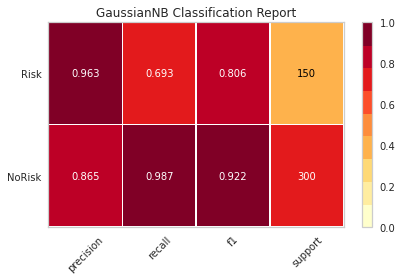

Confusion matrix, without normalization
[[296   4]
 [ 46 104]]


Normalized confusion matrix
[[0.99 0.01]
 [0.31 0.69]]


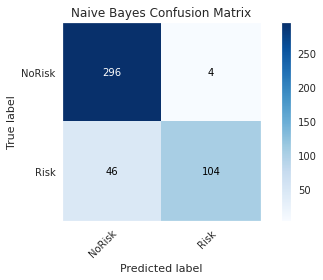

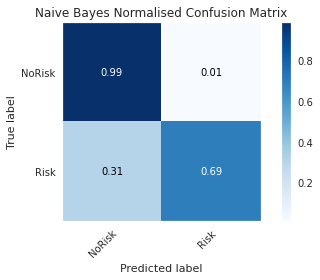

In [ ]:
# Instantiate the classification model and visualizer
visualizer = ClassificationReport(gnb, classes=['NoRisk','Risk'], support=True)
visualizer.fit(x_train, y_train) # Fit the training data to the visualizer
visualizer.score(x_test, y_test) # Evaluate the model on the test data
bayesclass = visualizer.poof() # Draw/show/poof the data

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, pred, classes=classes,
                      title='Naive Bayes Confusion Matrix')
print("\n")
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, pred, classes=classes, normalize=True,
                      title='Naive Bayes Normalised Confusion Matrix')

This is much more useful in percentile form, now we can see the values of our matrix, and also how that equates in a percentile form for a more accurate error matrix.

Cross-validation will be used to check the model against the entire dataset, split into k-folds. This is done to check to make sure the accuracy the model achieves an accuracy that is no effected by any bias or overfitting.

In [ ]:
#create an object of the type GaussianNB
gnb = GaussianNB()
#Train the algorithm
gauss_score = cross_val_score(gnb, x, y, cv= 10, scoring='accuracy')
print(gauss_score)
print("\n")
print("Naive Bayes Cross-Validation Accuracy : %0.2f (+/- %0.2f)" % \
      (gauss_score.mean(), gauss_score.std() * 2))

[0.89 0.93 0.89 0.93 0.93 0.91 0.86 0.87 0.89 0.91]


Naive Bayes Cross-Validation Accuracy : 0.90 (+/- 0.05)


The mean accuracy here is shown above, which looks to be in line with what we get when we run it on our train/test split, which is good. Looking at the 10 scores we get, most sit around where we expect, with only 2 dipping to 0.86 and 0.87 respectively. 

The variance of the accuracy scores is 0.05. Below are the same classification report and confusion matrix that was made before, but instead for cross validation. 

As cross_val_score cannot be used to create prediction reports such as the classification report, we need to use cross_val_predict instead here.

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html

In [ ]:
#create a confusion matrix for the dataset through cross validation folds
y_pred = cross_val_predict(gnb, x, y, cv=10)
print(metrics.classification_report(y, y_pred))
conf_mat = confusion_matrix(y, y_pred)
print(conf_mat)
print("\n")
print('Mean Absolute Error:', metrics.mean_absolute_error(y, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y, y_pred))
#print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y, y_pred)))

              precision    recall  f1-score   support

           0       0.88      0.98      0.93      1000
           1       0.95      0.74      0.83       500

    accuracy                           0.90      1500
   macro avg       0.92      0.86      0.88      1500
weighted avg       0.91      0.90      0.90      1500

[[981  19]
 [131 369]]


Mean Absolute Error: 0.1
Mean Squared Error: 0.1


## Linear SVC Model

Creating the Linear Support Vector Classification model.

SVM Classifiers offer good accuracy and perform faster prediction compared to Naïve Bayes algorithm. They also use less memory because they use a subset of training points in the decision phase. SVM works well with a clear margin of separation and with high dimensional space.

Lets begin creating the model.

In [ ]:
svc_model = LinearSVC()
#train the algorithm on training data and predict using the testing data
pred = svc_model.fit(x_train, y_train).predict(x_test)
#print the accuracy score of the model
svcaccuracy = accuracy_score(y_test, pred, normalize = True)
print("LinearSVC classification accuracy score : %0.2f " % svcaccuracy)

LinearSVC classification accuracy score : 0.97 


The accuracy is very good for this model when no hyper-parameters are adjusted. 
Changes to hyper-parameters for this model don't change the model accuracy much, setting fit_intercept to False doesn't change the accuracy whilst using class weight as baalnced reduces accuracy by 1%.

Lets create the classification report and confusion matrix for this model, as well as calculate the mean error metrics.

In [ ]:
print(metrics.classification_report(y_test, pred))
cf_svc = confusion_matrix(y_test, pred)
print(cf_svc)
print("\n")
linearsqr = metrics.mean_squared_error(y_test, pred)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, pred))
#print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, pred)))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       300
           1       0.96      0.95      0.95       150

    accuracy                           0.97       450
   macro avg       0.97      0.96      0.96       450
weighted avg       0.97      0.97      0.97       450

[[294   6]
 [  8 142]]


Mean Absolute Error: 0.03111111111111111
Mean Squared Error: 0.03111111111111111


As before, we have our classification report and confusion matrix (see below for visual representation). We can see a very high achieved accuracy in all areas in the report, not unexpected if you consider the model achieves an accuracy of 97%. What is important to notice is that the model is not lacking in any area, and all results are very equal in terms of percentile accuracy.

The lowest accuracies are in the areas of Precision, Recall and F1 Score for Risk prediction.

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  "X does not have valid feature names, but"


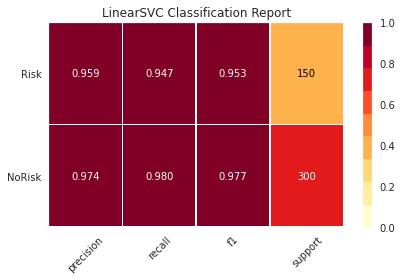

Confusion matrix, without normalization
[[294   6]
 [  8 142]]


Normalized confusion matrix
[[0.98 0.02]
 [0.05 0.95]]


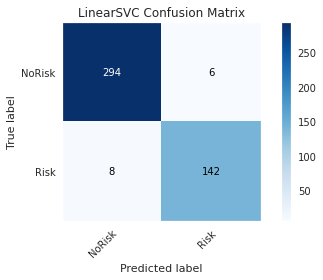

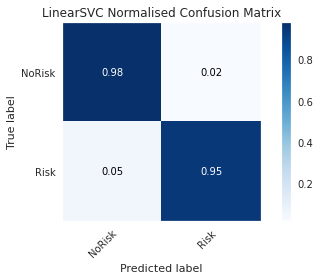

In [ ]:
# Instantiate the classification model and visualizer
visualizer = ClassificationReport(svc_model, classes=['NoRisk','Risk'], support=True)
visualizer.fit(x_train, y_train) # Fit the training data to the visualizer
visualizer.score(x_test, y_test) # Evaluate the model on the test data
g = visualizer.poof() # Draw/show/poof the data

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, pred, classes=classes,
                      title='LinearSVC Confusion Matrix')
print("\n")
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, pred, classes=classes, normalize=True,
                      title='LinearSVC Normalised Confusion Matrix')

Again, lets run cross validation against this to make sure we are not overfitting and getting an accuracy higher than we should be.

In [ ]:
svc_model = LinearSVC()
#Train the algorithm
svcscore = cross_val_score(svc_model, x, y, cv = 10, scoring='accuracy')
print(svcscore)
print("\n")
print("Linear SVC Cross-Validation Accuracy : %0.2f (+/- %0.2f)" % \
      (svcscore.mean(), svcscore.std() * 2))

[0.98 0.97 1.   0.97 0.99 0.99 0.95 0.95 0.99 0.96]


Linear SVC Cross-Validation Accuracy : 0.97 (+/- 0.03)


The 10 scores look good, the model hits good accuracy for the majoirty of the k-folds, similar to what is achieved with the train/test split, in most cases actually achieving higher overall than with the train/test split.

This is visualised below for easier readability.

In [ ]:
y_pred = cross_val_predict(svc_model, x, y, cv = 10)
print(metrics.classification_report(y, y_pred))
conf_mat = confusion_matrix(y, y_pred)
print(conf_mat)
print("\n")
print('Mean Absolute Error:', metrics.mean_absolute_error(y, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y, y_pred))
#print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y, y_pred)))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1000
           1       0.98      0.95      0.96       500

    accuracy                           0.97      1500
   macro avg       0.97      0.97      0.97      1500
weighted avg       0.97      0.97      0.97      1500

[[988  12]
 [ 27 473]]


Mean Absolute Error: 0.026
Mean Squared Error: 0.026


## K-Nearest Neighbours Model

KNN or K-Nearest-Neighbours is a simple and easy to implement algorithm. This algorithm assumes that similar things exist in close proximity, which we define as K.

It is possible to achieve varying results of accuracy by doing something as simple as changing the sum of K for the model. As the data in the train/test split totals 450, 5 seems like the best k to start with.

It is important to note that your K value shouldn't ever really be an even number, this is because an even number can have ties in its results, but this can be avoided by simply choosing an odd number for K.

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(x_train, y_train)
# predict the response
pred = neigh.predict(x_test)
# evaluate accuracy
knnaccuracy = accuracy_score(y_test, pred, normalize = True)
print ("KNeighbors K=5 classification accuracy score : %0.2f " % knnaccuracy)

KNeighbors K=5 classification accuracy score : 0.96 


In the case of K = 5, the model achieves a good accuracy. The classification report and confusion matrix are created below, to get a better visual idea of how the results are spread out.

In [ ]:
print(metrics.classification_report(y_test, pred))
cf_knn = confusion_matrix(y_test, pred)
print(cf_knn)
print("\n")
knnsqr = metrics.mean_squared_error(y_test, pred)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, pred))
#print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, pred)))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       300
           1       0.94      0.93      0.94       150

    accuracy                           0.96       450
   macro avg       0.95      0.95      0.95       450
weighted avg       0.96      0.96      0.96       450

[[291   9]
 [ 10 140]]


Mean Absolute Error: 0.042222222222222223
Mean Squared Error: 0.042222222222222223


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"


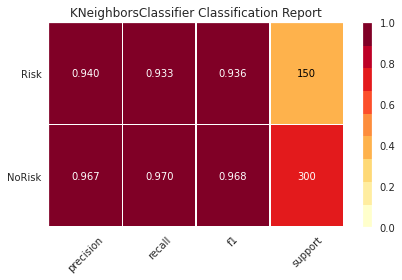

Confusion matrix, without normalization
[[291   9]
 [ 10 140]]


Normalized confusion matrix
[[0.97 0.03]
 [0.07 0.93]]


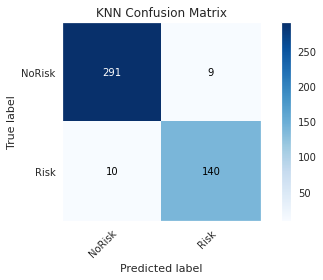

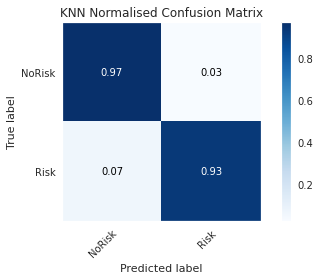

In [ ]:
# Instantiate the classification model and visualizer
visualizer = ClassificationReport(neigh, classes=['NoRisk','Risk'], support=True)
visualizer.fit(x_train, y_train) # Fit the training data to the visualizer
visualizer.score(x_test, y_test) # Evaluate the model on the test data
g = visualizer.poof() # Draw/show/poof the data

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, pred, classes=classes,
                      title='KNN Confusion Matrix')
print("\n")
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, pred, classes=classes, normalize=True,
                      title='KNN Normalised Confusion Matrix')

The percentile results in this classification report look very similar to what was achieved with LinearSVC. What is very interesting is, although we did achieve a more or less similar accuracy result, if we look at the matrix, we have

291-9 and 10-140, in our LinearSVC these numbers were 292-8 and 9-141. 

This shows that the models achieve a similar accuracy, but the LinearSVC gets 2 more classifications correct.

Our normalised confusion matrix shows a 97% precision for NoRisk classification and a 93% precision for Risk classification.

Lets run cross validation on KNN and see how it differs again from the train/test split we did before.

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=5)
#Train the algorithm
knnscore = cross_val_score(neigh, x, y, cv=10, scoring='accuracy')
print(knnscore)
print("\n")
print("KNeighbours Cross-Validation Accuracy : %0.2f (+/- %0.2f)" % \
      (knnscore.mean(), knnscore.std() * 2))

[0.99 0.97 0.97 0.99 0.98 0.97 0.94 0.97 0.97 0.94]


KNeighbours Cross-Validation Accuracy : 0.97 (+/- 0.03)


CV achieves a mean accuracy of 97% with a variance of 0.03. The scores themselves stay near 98% except for a couple of scores at 94%, which decreases the mean to 97.

In [ ]:
y_pred = cross_val_predict(neigh, x, y, cv = 10)
print(metrics.classification_report(y, y_pred))
conf_mat = confusion_matrix(y, y_pred)
print(conf_mat)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1000
           1       0.96      0.95      0.95       500

    accuracy                           0.97      1500
   macro avg       0.97      0.96      0.97      1500
weighted avg       0.97      0.97      0.97      1500

[[979  21]
 [ 25 475]]


### Finding the best value for K for the KNN model

The K value can have an impact on what sort of accuracy the model achieves, due to the way KNN works. Lets run a comparison and visualise it within a graph, to see how increasing the K value changes the accuracy.

In [ ]:
#search for an optimal value for K for KNN
k_range = range(1, 31)
k_scores = []
for k in k_range:
    neigh = KNeighborsClassifier(n_neighbors=k)
    knnscore = cross_val_score(neigh, x, y, cv=10, scoring='accuracy')
    k_scores.append(knnscore.mean())
print(k_scores)

[0.9879999999999999, 0.9833333333333332, 0.9786666666666666, 0.9733333333333334, 0.9693333333333334, 0.9706666666666666, 0.9646666666666667, 0.9606666666666668, 0.96, 0.954, 0.952, 0.9453333333333334, 0.9486666666666667, 0.9446666666666668, 0.946, 0.9460000000000001, 0.9446666666666668, 0.9460000000000001, 0.9406666666666667, 0.9406666666666667, 0.9413333333333332, 0.9373333333333334, 0.9366666666666668, 0.9306666666666666, 0.9313333333333332, 0.9273333333333333, 0.9273333333333333, 0.9173333333333332, 0.9166666666666666, 0.9099999999999999]


We have the scores, now lets plot the graph. We will use the range of K as our x value, and the accuracy scores as the y value.

Text(0, 0.5, 'Cross-Validated Accuracy')

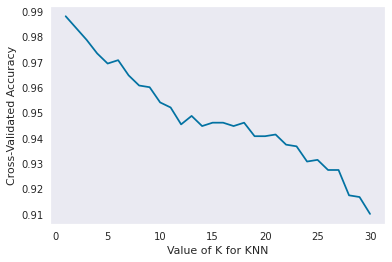

In [ ]:
plt.plot(k_range,k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

The graph shows that for this dataset, as the K value is increased, there is a decrease in accuracy measurement, dropping to as low as 92% when K is at the maximum tested value of 31.

What's interesting is that while 92% is the lowest accuracy achieved for K = 31, this accuracy is still higher than that which the Naive Bayes model managed to achieve.

The optimal K value appears to be 1, but that is not a good choice. If K = 1, there will be a higher bias.

When K increases, the training error will increase (increase bias), but the test error may decrease at the same time (decrease variance). When K becomes larger, since it has to consider more neighbors, its model is more complex.

For the reason of keeping the K value as an odd number and avoiding 1, lets go with 3 as the new K value and run cross validation again.

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=3)
#Train the algorithm
knnscore = cross_val_score(neigh, x, y, cv=10, scoring='accuracy')
print(knnscore)
print("\n")
print("KNeighbours Cross-Validation Accuracy : %0.2f (+/- %0.2f)" % \
      (knnscore.mean(), knnscore.std() * 2))

[1.   0.98 0.97 0.99 0.98 0.99 0.96 0.99 0.97 0.95]


KNeighbours Cross-Validation Accuracy : 0.98 (+/- 0.03)


Looking at the scores for the 10 cross validation folds, there is a noticeable 100% accuracy in the first run. The results stay around 98% for the rest of the tests, concluding with a mean accuracy score of 98%, with a variance of 0.03.

lets compute the results into a classification report and confusion matrix to see these scores in more depth.

In [ ]:
y_pred = cross_val_predict(neigh, x, y, cv = 10)
print(metrics.classification_report(y, y_pred))
conf_mat = confusion_matrix(y, y_pred)
print(conf_mat)
print("\n")
print('Mean Absolute Error:', metrics.mean_absolute_error(y, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y, y_pred))
#print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y, y_pred)))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1000
           1       0.97      0.97      0.97       500

    accuracy                           0.98      1500
   macro avg       0.98      0.98      0.98      1500
weighted avg       0.98      0.98      0.98      1500

[[985  15]
 [ 17 483]]


Mean Absolute Error: 0.021333333333333333
Mean Squared Error: 0.021333333333333333


Since K = 3 is slightly better, lets again run the model on the test data like before.

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(x_train, y_train)
# predict the response
pred = neigh.predict(x_test)
# evaluate accuracy
knnaccuracy = accuracy_score(y_test, pred, normalize = True)
print ("KNeighbors K=3 classification accuracy score : %0.2f " % knnaccuracy)

KNeighbors K=3 classification accuracy score : 0.96 


In [ ]:
print(metrics.classification_report(y_test, pred))
cf_knn = confusion_matrix(y_test, pred)
print(cf_knn)

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       300
           1       0.94      0.94      0.94       150

    accuracy                           0.96       450
   macro avg       0.95      0.95      0.95       450
weighted avg       0.96      0.96      0.96       450

[[291   9]
 [  9 141]]


With K=3 for the model, the difference is an additional False Negative correct result, not a huge difference.

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"


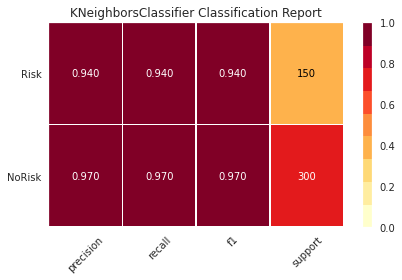

Confusion matrix, without normalization
[[291   9]
 [  9 141]]


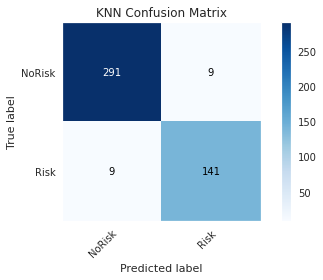

In [ ]:
# Instantiate the classification model and visualizer
visualizer = ClassificationReport(neigh, classes=['NoRisk','Risk'], support=True)
visualizer.fit(x_train, y_train) # Fit the training data to the visualizer
visualizer.score(x_test, y_test) # Evaluate the model on the test data
g = visualizer.poof() # Draw/show/poof the data

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, pred, classes=classes,
                      title='KNN Confusion Matrix')

## Logistic Regression

Logistic Regression is an algorithm similar to Linear Regression, but it does a better job at making a prediction based on a binary output, in this case 0 and 1, which are associated with the norisk and risk target.

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

Set the solver to lbfgs, this means it will handle multinomial loss. The max iter is set to 1000, the default for this is 100, but to make sure there are no convergence errors, lets increase this.

In [ ]:
# multiclass 'auto' selects 'ovr' if the data is binary, or if solver='liblinear',
# otherwise selects 'multinomial'.

logreg =LogisticRegression(solver='lbfgs', max_iter=1000, multi_class="auto")
logreg.fit(x_train, y_train)
# predict the response
pred = logreg.predict(x_test)
# evaluate accuracy
logregaccuracy = accuracy_score(y_test, pred, normalize = True)
print ("Logistic Regression classification accuracy score : %0.2f " % logregaccuracy)
cf_lr = confusion_matrix(y_test, pred)
print(cf_lr)

Logistic Regression classification accuracy score : 0.96 
[[294   6]
 [ 14 136]]


Lets try changing the solver to a different option as lbfgs is mostly only useful for multi-class problems, which this is not.

In [ ]:
logreg =LogisticRegression(solver='liblinear', max_iter=1000, multi_class="auto")
logreg.fit(x_train, y_train)
# predict the response
pred = logreg.predict(x_test)
# evaluate accuracy
logregaccuracy = accuracy_score(y_test, pred, normalize = True)
print ("Logistic Regression classification accuracy score : %0.2f " % logregaccuracy)
cf_lr = confusion_matrix(y_test, pred)
print(cf_lr)

Logistic Regression classification accuracy score : 0.94 
[[288  12]
 [ 16 134]]


It gets worse. lets try adjusting the penalty, which defaults to l2 and adding class_weight = balanced.

In [ ]:
# Adding class weight into the previously best model of the above tests
logreg =LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000, multi_class="auto",\
                          class_weight='balanced')
logreg.fit(x_train, y_train)
# predict the response
pred = logreg.predict(x_test)
# evaluate accuracy
logregaccuracy = accuracy_score(y_test, pred, normalize = True)
print ("Logistic Regression classification accuracy score : %0.2f " % logregaccuracy)
cf_lr = confusion_matrix(y_test, pred)
print(cf_lr)

Logistic Regression classification accuracy score : 0.96 
[[290  10]
 [  8 142]]


Here there is an increase in Positive classification results, how about l1 penalty without class weight . 

In [ ]:
logreg =LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000, multi_class="auto")
logreg.fit(x_train, y_train)
# predict the response
pred = logreg.predict(x_test)
# evaluate accuracy
logregaccuracy = accuracy_score(y_test, pred, normalize = True)
print ("Logistic Regression classification accuracy score : %0.2f " % logregaccuracy)
cf_lr = confusion_matrix(y_test, pred)
print(cf_lr)

Logistic Regression classification accuracy score : 0.97 
[[294   6]
 [  8 142]]


By adding the class weight hyper-parameter as balanced, the model slightly worsens.

The accuracy is 97% with adjusted hyper-parameters.

The default hyper-parameters have been slightly adjusted here. The default solver is changed from the default, and the max iterations have been increased from 100 to 1000.

Not setting a solver results in lbfgs being the default and a warning being shown.

More stats are available below in the classification report and confusion matrix.

In [ ]:
print(metrics.classification_report(y_test, pred))
print(cf_lr)
print("\n")
logregsqr = metrics.mean_squared_error(y_test, pred)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, pred))
#print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, pred)))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       300
           1       0.96      0.95      0.95       150

    accuracy                           0.97       450
   macro avg       0.97      0.96      0.96       450
weighted avg       0.97      0.97      0.97       450

[[294   6]
 [  8 142]]


Mean Absolute Error: 0.03111111111111111
Mean Squared Error: 0.03111111111111111


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"


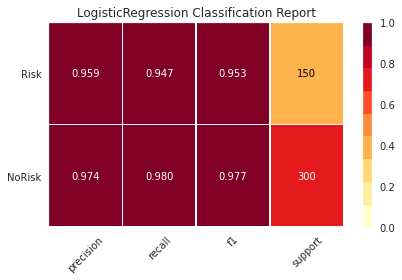

Confusion matrix, without normalization
[[294   6]
 [  8 142]]


Normalized confusion matrix
[[0.98 0.02]
 [0.05 0.95]]


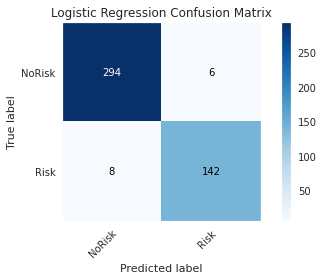

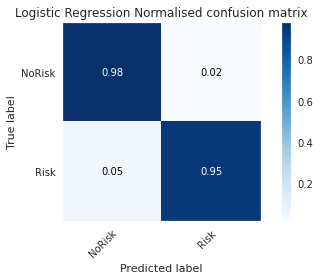

In [ ]:
# Instantiate the classification model and visualizer
visualizer = ClassificationReport(logreg, classes=['NoRisk','Risk'], support=True)
visualizer.fit(x_train, y_train) # Fit the training data to the visualizer
visualizer.score(x_test, y_test) # Evaluate the model on the test data
g = visualizer.poof() # Draw/show/poof the data

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, pred, classes=classes,
                      title='Logistic Regression Confusion Matrix')
print("\n")
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, pred, classes=classes, normalize=True,
                      title='Logistic Regression Normalised confusion matrix')

For our TP and TN, we maintain good percentile scores of 98% and 95% respectively.

Lets take a look again at cross validation for this model solution, to see if anything changes.

In [ ]:
logreg = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000, multi_class="auto",\
                          class_weight='balanced')
logregscore = cross_val_score(logreg, x, y, cv=10, scoring='accuracy')
print(logregscore)
print("\n")
print("Logistic Regression Cross-Validation Accuracy : %0.2f (+/- %0.2f)" % \
      (logregscore.mean(), logregscore.std() * 2))

[0.99 0.98 0.99 0.97 0.97 0.99 0.95 0.93 0.98 0.97]


Logistic Regression Cross-Validation Accuracy : 0.97 (+/- 0.04)


There is a small accuracy increase here, with good high accuracy scores within the 10 runs. Our mean score is 97% with the variance coming up as 0.03, similar to the variance found within previous models too.

Classification report and confusion matrix for cross validation are also shown.

In [ ]:
y_pred = cross_val_predict(logreg, x, y, cv = 10)
print(metrics.classification_report(y, y_pred))
conf_mat = confusion_matrix(y, y_pred)
print(conf_mat)
print("\n")
print('Mean Absolute Error:', metrics.mean_absolute_error(y, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y, y_pred))
#print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y, y_pred)))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1000
           1       0.96      0.96      0.96       500

    accuracy                           0.97      1500
   macro avg       0.97      0.97      0.97      1500
weighted avg       0.97      0.97      0.97      1500

[[978  22]
 [ 19 481]]


Mean Absolute Error: 0.027333333333333334
Mean Squared Error: 0.027333333333333334


## Decision Tree

One of the most important models is the Decision Tree. The best reason to use a decision tree, is to get a visual view as to how the algorithm splits the training data and comes to the decision that is seen at the end when it begins to predict results.

Lets fit the data to the model, and get our accuracy score.

In [ ]:
#Create the decision tree classifier
clf = tree.DecisionTreeClassifier(max_depth=5, class_weight='balanced')
#adjusting max depth increases accuracy, all the way up to depth of 10 = 99% accuracy
#but this is hard to visually understand

#Train the classifier
clf = clf.fit(x_train, y_train)

#Predict what the response will be for the test dataset
pred = clf.predict(x_test)

#Model Accuracy
treeaccuracy = accuracy_score(y_test, pred, normalize = True)
print ("Decision Tree classification accuracy score : %0.2f " % treeaccuracy)

Decision Tree classification accuracy score : 0.97 


Accuracy is good, at 97% with class weight set to balanced. Increasing the max depth will of course increase the accuracy, but can introduce overfitting of the model.

Important note about max depth - The max depth, defines how far in the depth the decision tree will go, from top to bottom. As expected a higher depth will allow a higher prediction accuracy, but also results in a higher chance of overfitting skewing the result of the model.

#### Visualising the Decision Tree

To visualise the decision tree, we will use the export feature of sklearn.tree called export_graphviz, which allows us to visualise our graph, and then save that as a file if we want it later on outside of the notebook.

https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html

We define the feature names, and make sure to attach the training model to this. This will give us a graphical overview of the decision tree and how it comes to its decisions. The default separator for impurity score is Gini, which is not changed for the below visualisation. This can be changed to Entropy, if desired.

The Gini score is a metric that quantifies the purity of the node/leaf.
A Gini score greater than zero implies that samples contained within that node belong to different classes. 

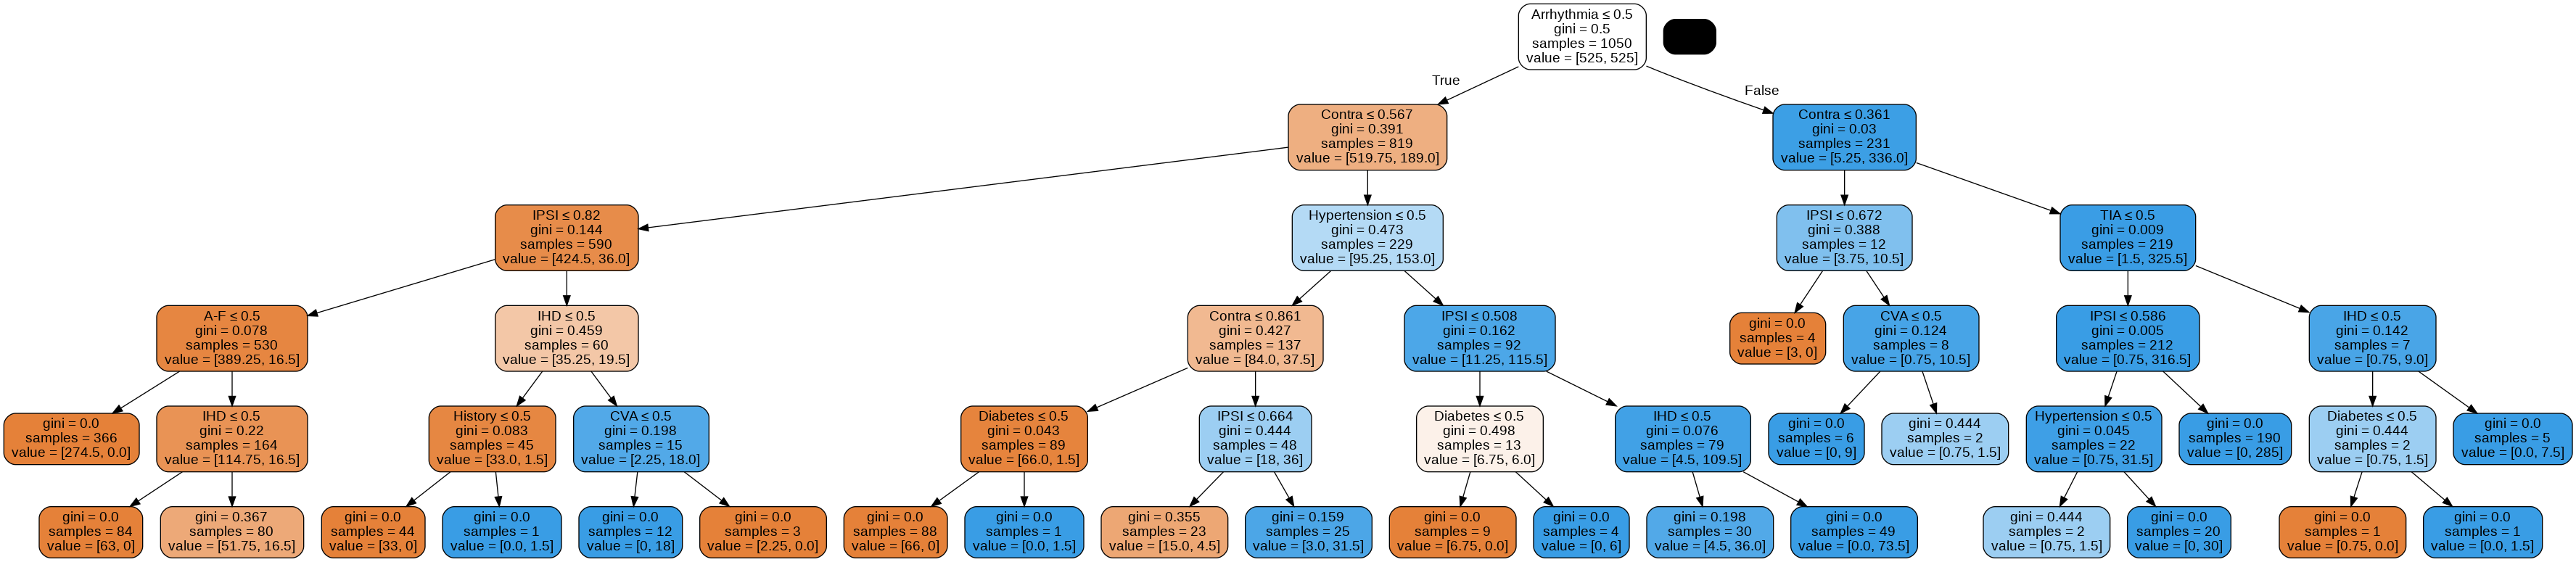

In [ ]:
features = list(x.columns)

tree.export_graphviz(clf, out_file='tree.dot',
               filled=True, 
                     rounded=True,
                     special_characters=True, 
                     feature_names = features)

graph = pydotplus.graph_from_dot_file('tree.dot')
Image(graph.create_png())

From this decision tree, we can see how the model traisn itself on the data and target we give it. It is interesting to see how it begins initial split at the top of the tree. It uses Arrhythmia to split at the first step, then uses Contra, and so on.

In [ ]:
print(metrics.classification_report(y_test, pred))
cf_dt = confusion_matrix(y_test, pred)
print(cf_dt)
print("\n")
dtsqr = metrics.mean_squared_error(y_test, pred)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, pred))
#print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, pred)))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       300
           1       0.94      0.97      0.95       150

    accuracy                           0.97       450
   macro avg       0.96      0.97      0.97       450
weighted avg       0.97      0.97      0.97       450

[[291   9]
 [  5 145]]


Mean Absolute Error: 0.03111111111111111
Mean Squared Error: 0.03111111111111111


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  "X does not have valid feature names, but"


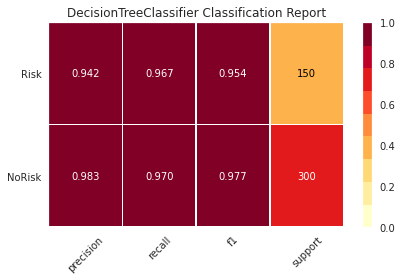

Confusion matrix, without normalization
[[291   9]
 [  5 145]]


Normalized confusion matrix
[[0.97 0.03]
 [0.03 0.97]]


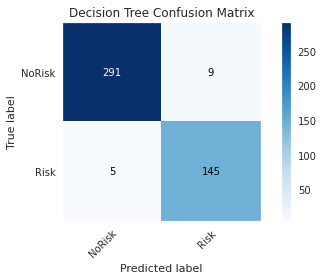

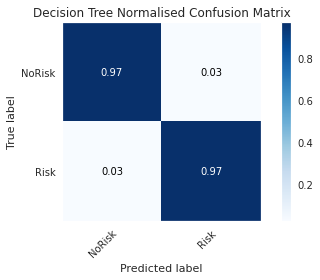

In [ ]:
# Instantiate the classification model and visualizer
visualizer = ClassificationReport(clf, classes=['NoRisk','Risk'], support=True)
visualizer.fit(x_train, y_train) # Fit the training data to the visualizer
visualizer.score(x_test, y_test) # Evaluate the model on the test data
g = visualizer.poof() # Draw/show/poof the data

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, pred, classes=classes,
                      title='Decision Tree Confusion Matrix')
print("\n")
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, pred, classes=classes, normalize=True,
                      title='Decision Tree Normalised Confusion Matrix')

The lowest accuracy score in the report here is the Risk precision of 94%. What this means is that the decision tree had the most trouble classifying a Risk based on the data it was trained on, but overall the scores are still good, but this shows where improvement could be made.

The Decision Tree model does a good job of making the predictions however, where we have 3% on both FP and FN.

It is not possible to visualise the Decision Tree for cross validation without fitting to the tree, so the accuracy result is looked at instead rather than a visualised tree like before.

In [ ]:
clf = tree.DecisionTreeClassifier(max_depth=5, class_weight='balanced')
dtscore = cross_val_score(clf, x, y, cv=10, scoring='accuracy')
print(dtscore)
print("\n")
print("Decision Tree Cross-Validation Accuracy : %0.2f (+/- %0.2f)" % \
      (dtscore.mean(), dtscore.std() * 2))

[0.97 0.96 0.99 0.95 0.98 0.98 0.95 0.97 0.98 0.97]


Decision Tree Cross-Validation Accuracy : 0.97 (+/- 0.03)


Cross validation is ran using the same depth as before of 5, the same mean accuracy is achieved, with a pretty standard variance of 0.03.

In [ ]:
y_pred = cross_val_predict(clf, x, y, cv = 10)
print(metrics.classification_report(y, y_pred))
conf_mat = confusion_matrix(y, y_pred)
print(conf_mat)

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1000
           1       0.96      0.95      0.95       500

    accuracy                           0.97      1500
   macro avg       0.97      0.96      0.97      1500
weighted avg       0.97      0.97      0.97      1500

[[981  19]
 [ 26 474]]


In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y, y_pred))
#print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y, y_pred)))

Mean Absolute Error: 0.03
Mean Squared Error: 0.03


It is possible to visualise the predictions of the Decision Tree in a format such as that of a prediction to actual dataframe, DecisionTreeRegressor function of sklearn can be used for this.

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

In [ ]:
regressor = DecisionTreeRegressor()
regressor.fit(x_train, y_train)

y_pred = regressor.predict(x_test)

df=pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})
df.head(10)

,Actual,Predicted
1069,0,0.0
1070,1,1.0
1071,0,0.0
1072,1,1.0
1073,0,0.0
1074,1,1.0
1075,0,0.0
1076,0,0.0
1077,0,0.0
1078,0,0.0


## Neural Network 

The last model that will be trained is a Neural Network. 

A Neural Network, is essentially a series of algorithms that endeavors to recognise underlying relationships in a set of data through a process that mimics the way the human brain operates.
It is a very popular technique in the field of Deep Learning.

Lets start by using a sgd solver using the settings below and the learning rate set as invscaling.
From the documentation - 'invscaling' gradually decreases the learning rate at each
      time step 't' using an inverse scaling exponent of 'power_t'.
      effective_learning_rate = learning_rate_init / pow(t, power_t)

In [ ]:
mlp = MLPClassifier(solver='sgd', max_iter=5000, hidden_layer_sizes=(100),\
                    batch_size='auto', random_state=1, verbose=0, learning_rate='invscaling')
mlp.fit(x_train, y_train)

pred = mlp.predict(x_test)
nnaccuracy = accuracy_score(y_test,pred, normalize=True)
print ("Neural Network classification accuracy score : %0.2f " % nnaccuracy)
cf_nn = confusion_matrix(y_test, pred)
print(cf_nn)

Neural Network classification accuracy score : 0.55 
[[139 161]
 [ 43 107]]


It seems that invscaling has a very bad effect, in that the model achieves LESS then null accuracy. Lets try again, but lets set the learning rate to adaptive.

In [ ]:
mlp = MLPClassifier(solver='sgd', max_iter=5000, hidden_layer_sizes=(100),\
                    batch_size='auto', random_state=1, verbose=0, learning_rate='adaptive')
mlp.fit(x_train, y_train)

pred = mlp.predict(x_test)
nnaccuracy = accuracy_score(y_test,pred, normalize=True)
print ("Neural Network classification accuracy score : %0.2f " % nnaccuracy)
cf_nn = confusion_matrix(y_test, pred)
print(cf_nn)

Neural Network classification accuracy score : 0.93 
[[287  13]
 [ 20 130]]


Its better, but it can be improved. Lets try changing the batch size from automatic (200) to a smaller size of 10.

In [ ]:
mlp = MLPClassifier(solver='sgd', max_iter=5000, hidden_layer_sizes=(100),\
                    batch_size=10, random_state=1, verbose=0, learning_rate='adaptive')
mlp.fit(x_train, y_train)

pred = mlp.predict(x_test)
nnaccuracy = accuracy_score(y_test,pred, normalize=True)
print ("Neural Network classification accuracy score : %0.2f " % nnaccuracy)
cf_nn = confusion_matrix(y_test, pred)
print(cf_nn)

Neural Network classification accuracy score : 0.97 
[[294   6]
 [  8 142]]


This shows a minor increase, but an increase nonetheless that is positive. lets try increasing the iterations to 10000, and the hidden layer sizes to 1000 to see if it gets any better.

In [ ]:
mlp = MLPClassifier(solver='sgd', max_iter=10000, hidden_layer_sizes=(1000),\
                    batch_size=10, random_state=1, verbose=0, learning_rate='adaptive')
mlp.fit(x_train, y_train)

pred = mlp.predict(x_test)
nnaccuracy = accuracy_score(y_test,pred, normalize=True)
print ("Neural Network classification accuracy score : %0.2f " % nnaccuracy)
cf_nn = confusion_matrix(y_test, pred)
print(cf_nn)

Neural Network classification accuracy score : 0.97 
[[294   6]
 [  8 142]]


Same result. Ok lets try changing our solver, it's set to sgd right now, which is stochastic gradient descent. Lets try out lbfgs, which is a lot better for smaller datasets.

In [ ]:
mlp = MLPClassifier(solver='lbfgs', max_iter=10000, hidden_layer_sizes=(1000),\
                    batch_size=10, random_state=1, verbose=0, learning_rate='adaptive')
mlp.fit(x_train, y_train)

pred = mlp.predict(x_test)
nnaccuracy = accuracy_score(y_test,pred, normalize=True)
print ("Neural Network classification accuracy score : %0.2f " % nnaccuracy)
cf_nn = confusion_matrix(y_test, pred)
print(cf_nn)

Neural Network classification accuracy score : 0.98 
[[298   2]
 [  6 144]]


The results are really good now, but the last thing worth trying, is reducing the max iterations and hidden layer sizes back to what we had before, to see if anything changes.

In [ ]:
mlp = MLPClassifier(solver='lbfgs', max_iter=5000, hidden_layer_sizes=(100),\
                    batch_size=10, random_state=1, verbose=0, learning_rate='adaptive')
mlp.fit(x_train, y_train)

pred = mlp.predict(x_test)
nnaccuracy = accuracy_score(y_test,pred, normalize=True)
print ("Neural Network classification accuracy score : %0.2f " % nnaccuracy)
cf_nn = confusion_matrix(y_test, pred)
print(cf_nn)

Neural Network classification accuracy score : 0.98 
[[295   5]
 [  3 147]]


The difference is small, but its there. The results scale more towards the target, so this will be maintained.

In [ ]:
print(metrics.classification_report(y_test, pred))
print("\n")
nnsqr = metrics.mean_squared_error(y_test, pred)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, pred)))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       300
           1       0.97      0.98      0.97       150

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



Mean Absolute Error: 0.017777777777777778
Mean Squared Error: 0.017777777777777778


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


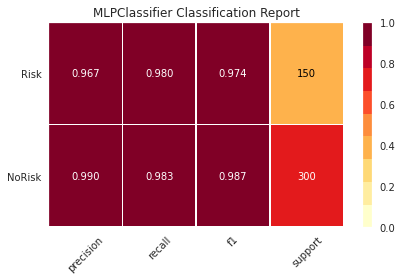

Confusion matrix, without normalization
[[295   5]
 [  3 147]]


Normalized confusion matrix
[[0.98 0.02]
 [0.02 0.98]]


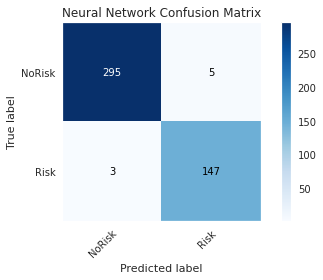

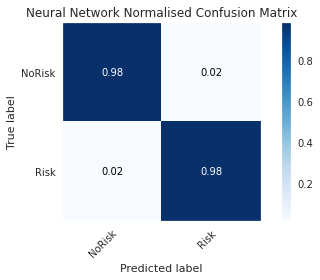

In [ ]:
# Instantiate the classification model and visualizer
visualizer = ClassificationReport(mlp, classes=['NoRisk','Risk'], support=True)
visualizer.fit(x_train, y_train) # Fit the training data to the visualizer
visualizer.score(x_test, y_test) # Evaluate the model on the test data
g = visualizer.poof() # Draw/show/poof the data

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, pred, classes=classes,
                      title='Neural Network Confusion Matrix')
print("\n")
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, pred, classes=classes, normalize=True,
                      title='Neural Network Normalised Confusion Matrix')

#### Neural Net Cross Validation

In [ ]:
mlp = MLPClassifier(solver='lbfgs', max_iter=5000, hidden_layer_sizes=(100),\
                    batch_size=10, random_state=1, verbose=0, learning_rate='adaptive')
#Train the algorithm
nnscore = cross_val_score(mlp, x, y, cv=10, scoring='accuracy')
print(nnscore)
print("\n")
print("Neural Net Cross-Validation Accuracy : %0.2f (+/- %0.2f)" % \
      (nnscore.mean(), nnscore.std() * 2))

[1.   0.99 0.99 0.99 0.99 0.99 0.97 0.99 1.   0.99]


Neural Net Cross-Validation Accuracy : 0.99 (+/- 0.02)


Cross Validation Neural Network score is 99%, with some k-folds hitting 100%. The results are fantastic and very accurate, looking at the overall dataset in a confusion matrix shows that the Neural Network ran against the entire dataset gets a total of 17 predictions wrong out of a total of 1500.

In [ ]:
y_pred = cross_val_predict(mlp, x, y, cv = 10)
print(metrics.classification_report(y, y_pred))
conf_mat = confusion_matrix(y, y_pred)
print(conf_mat)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1000
           1       0.98      0.99      0.99       500

    accuracy                           0.99      1500
   macro avg       0.99      0.99      0.99      1500
weighted avg       0.99      0.99      0.99      1500

[[992   8]
 [  7 493]]


In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y, y_pred))
#print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y, y_pred)))

Mean Absolute Error: 0.01
Mean Squared Error: 0.01


# Evaluation

Once all 6 models have been trained and their results have been looked at, its important to evaluate findings about each model and discuss which performs best towards the task.

Below I have compiled the results that are deemed the most important towards an evaluation of each model and have put them all together to allow for quick and easy comparison.

#### Accuracy Scores

In [ ]:
print("Naive Bayes Accuracy Score : %0.2f" % nbaccuracy,"%")
print("Linear SVC Accuracy Score : %0.2f" % svcaccuracy,"%")
print("KNeighbours K=3 Accuracy Score : %0.2f" % knnaccuracy,"%")
print("Logistic Regression Accuracy Score : %0.2f" % logregaccuracy,"%")
print("Decision Tree Accuracy Score : %0.2f" % treeaccuracy,"%")
print("Neural Network Accuracy Score : %0.2f" % nnaccuracy,"%")

Naive Bayes Accuracy Score : 0.89 %
Linear SVC Accuracy Score : 0.97 %
KNeighbours K=3 Accuracy Score : 0.96 %
Logistic Regression Accuracy Score : 0.97 %
Decision Tree Accuracy Score : 0.97 %
Neural Network Accuracy Score : 0.98 %


Accuracy score, whilst a good baseline to see how a model is doing, is not the be all, end all metric to look at when evaluating models. Accuracy score tells you how well a model is doing towards the goal, but it doesn't show where each model is going wrong.

#### Cross Validation Accuracy scores

In [ ]:
print("Naive Bayes Cross-Validation Accuracy : %0.2f (+/- %0.2f)" % \
      (gauss_score.mean(), gauss_score.std() * 2))
print("Linear SVC Cross-Validation Accuracy : %0.2f (+/- %0.2f)" % \
      (svcscore.mean(), svcscore.std() * 2))
print("KNeighbours K=3 Cross-Validation Accuracy : %0.2f (+/- %0.2f)" % \
      (knnscore.mean(), knnscore.std() * 2))
print("Logistic Regression Cross-Validation Accuracy : %0.2f (+/- %0.2f)" % \
      (logregscore.mean(), logregscore.std() * 2))
print("Decision Tree Cross-Validation Accuracy : %0.2f (+/- %0.2f)" % \
      (dtscore.mean(), dtscore.std() * 2))
print("Neural Network Cross-Validation Accuracy : %0.2f (+/- %0.2f)" % \
      (nnscore.mean(), nnscore.std() * 2))

Naive Bayes Cross-Validation Accuracy : 0.90 (+/- 0.05)
Linear SVC Cross-Validation Accuracy : 0.97 (+/- 0.03)
KNeighbours K=3 Cross-Validation Accuracy : 0.98 (+/- 0.03)
Logistic Regression Cross-Validation Accuracy : 0.97 (+/- 0.04)
Decision Tree Cross-Validation Accuracy : 0.97 (+/- 0.03)
Neural Network Cross-Validation Accuracy : 0.99 (+/- 0.02)


Cross-Validation is used in this instance to check that the model accuracy that is achieved, is equivalent when the model is trained and tested on k-folds of the dataset. In all cases, the cross validation accuracy result mean score of all 10 runs is at a maximum, 2% higher. In most cases for the models trained here, the CV accuracy is 1% higher when the mean is taken into account. 

Variance is used alongside the result of each CV accuracy score to tell how far away the result is from the overall of all 10 results. The Variance of the accuracy results is usually 0.03, with a few having slightly different variance scores.

#### Mean Squared Error of each Model

In [ ]:
print("Naive Bayes Mean Squared Error : ", nbsqr)
print("Linear SVC Mean Squared Error :", linearsqr)
print("KNeighbours K=3 Mean Squared Error :", knnsqr)
print("Logistic Regression Mean Squared Error :", logregsqr)
print("Decision Tree Mean Squared Error :", dtsqr)
print("Neural Network Mean Squared Error :", nnsqr)

Naive Bayes Mean Squared Error :  0.1111111111111111
Linear SVC Mean Squared Error : 0.03111111111111111
KNeighbours K=3 Mean Squared Error : 0.042222222222222223
Logistic Regression Mean Squared Error : 0.03111111111111111
Decision Tree Mean Squared Error : 0.03111111111111111
Neural Network Mean Squared Error : 0.017777777777777778


Mean Squared Error is not a very important metric when evaluating classification models. These results are measured, but are not included in the report that accompanies the code, due to Confusion Matrices and Classification Reports being much better to compare and evaluate these models.

#### Confusion Matrices

In [ ]:
print("Naive Bayes Confusion Matrix :\n", cf_nb)
print("LinearSVC Confusion Matrix :\n", cf_svc)
print("KNeighbours Confusion Matrix :\n", cf_knn)
print("Logistic Regression Confusion Matrix :\n", cf_lr)
print("Decision Tree Confusion Matrix :\n", cf_dt)
print("Neural Network Confusion Matrix :\n", cf_nn)

Naive Bayes Confusion Matrix :
 [[296   4]
 [ 46 104]]
LinearSVC Confusion Matrix :
 [[294   6]
 [  8 142]]
KNeighbours Confusion Matrix :
 [[291   9]
 [  9 141]]
Logistic Regression Confusion Matrix :
 [[294   6]
 [  8 142]]
Decision Tree Confusion Matrix :
 [[291   9]
 [  5 145]]
Neural Network Confusion Matrix :
 [[295   5]
 [  3 147]]


A Confusion Matrix, aka Error Matrix aims to see where the model is correctly classifying positvie results and incorrect classifying these results. 

The most important metrics of the Confusion Matrix for the medical domain is False Positive and, in this task, False Negative. A False Negative is also known as a Type I error, these are deemed to be dangerous, as this is the misclassification that causes a patient to be thought to be safe, when they may require treatment. A False Positive is known as a Type II error, because it is deemed to be not as dangerous as Type I, and further medical analysis can resolve this sort of error.

#### Classification Reports

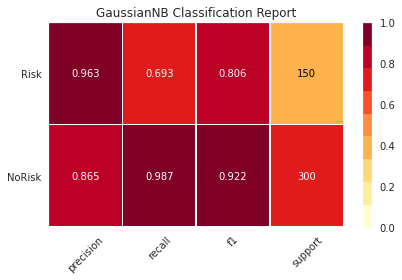

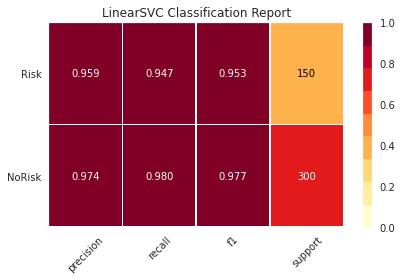

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"


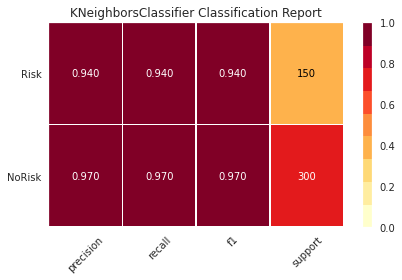

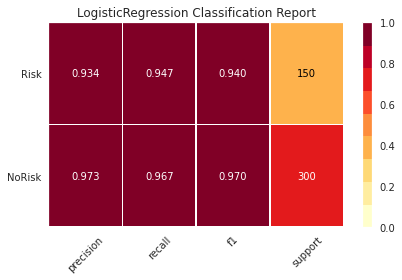

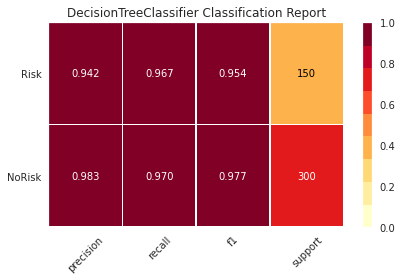

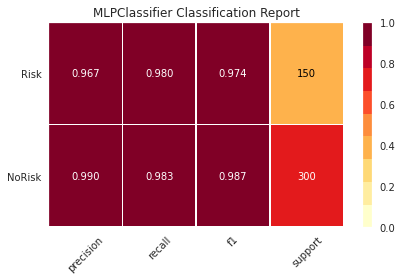

In [ ]:
visualizer = ClassificationReport(gnb, classes=['NoRisk','Risk'], support=True)
visualizer.fit(x_train, y_train) # Fit the training data to the visualizer
visualizer.score(x_test, y_test) # Evaluate the model on the test data
g = visualizer.poof() # Draw/show/poof the data

visualizer = ClassificationReport(svc_model, classes=['NoRisk','Risk'],support=True)
visualizer.fit(x_train, y_train) # Fit the training data to the visualizer
visualizer.score(x_test, y_test) # Evaluate the model on the test data
g = visualizer.poof() # Draw/show/poof the data

visualizer = ClassificationReport(neigh, classes=['NoRisk','Risk'],support=True)
visualizer.fit(x_train, y_train) # Fit the training data to the visualizer
visualizer.score(x_test, y_test) # Evaluate the model on the test data
g = visualizer.poof() # Draw/show/poof the data

visualizer = ClassificationReport(logreg, classes=['NoRisk','Risk'],support=True)
visualizer.fit(x_train, y_train) # Fit the training data to the visualizer
visualizer.score(x_test, y_test) # Evaluate the model on the test data
g = visualizer.poof() # Draw/show/poof the data

visualizer = ClassificationReport(clf, classes=['NoRisk','Risk'],support=True)
visualizer.fit(x_train, y_train) # Fit the training data to the visualizer
visualizer.score(x_test, y_test) # Evaluate the model on the test data
g = visualizer.poof() # Draw/show/poof the data

visualizer = ClassificationReport(mlp, classes=['NoRisk','Risk'],support=True)
visualizer.fit(x_train, y_train) # Fit the training data to the visualizer
visualizer.score(x_test, y_test) # Evaluate the model on the test data
g = visualizer.poof() # Draw/show/poof the data

Classification Reports help to see the difference within each model when it comes to The scores of Precision, Recall and F1 score. For the purpose of the task and for this domain, F1 score wasn't explored too much due to how much Sensitivity is more the target of assessment for the task and domain in question.

Overall the results of the models are good, and it is clear which is the best, but most models created would be good for deployment. Although deployment hasn't and won't be discused in this code portion. A brief discussion regarding deployment can be found in the report that accompanies this notebook.